##  Multilayer Perceptron Series 

# 1. Momentum and gradient descent

Momentum is yet another optimization trick to speed up gradient descent along long narrow valleys.

In [10]:
#  This code cell will not be shown in the HTML version of this notebook
# import autograd functionality
import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   

# import various other libraries
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

#  This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/superlearn_datasets/'
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.1  Momentum derivation and examples

- Slight modification of gradient descent (either version) to deal with *long narrow valleys* 


- gradient descent *zig-zags around* in these areas



- Occur in both convex and non-convex cost functions



- Basic problem: want to reduce the affect of gradient descent zig-zagging down long narrow valleys of cost functions, because gradient moves perpindicular to contours of a function
 
 
- Basic solution provided by momentum: add weighted difference of previous weight updates to even out the zig-zagging 


- e.g., for unnormalized version of gradient descent momentum added gradient descent update

\begin{equation}
\mathbf{w}^{k+1} = \mathbf{w}^k - \alpha \nabla g\left(\mathbf{w}^k\right) + \beta \left(\mathbf{w}^{k} - \mathbf{w}^{k-1}\right)
\end{equation}


- Here $0 \leq \beta < 1$ is a parameter that trades off the direction from the negative gradient direction and the difference of the two previous points. 

<p><img src= '../../mlrefined_images/nonlinear_superlearn_images/momentum_fig.png' width="80%" height="60%" alt=""/></p>

- Works the same for normalized gradient descent as well

- Momentum often written in equivalent manner but more mysterious mannar (see notes for details)

\begin{equation}
\begin{array}
\
\mathbf{z}^{k+1} = \beta\,\mathbf{z}^{k} + \nabla g\left(\mathbf{w}^k\right) \\
\mathbf{w}^{k+1} = \mathbf{w}^{k} - \alpha \, \mathbf{z}^{k+1}
\end{array}
\end{equation}

- Can show this is equivalent by subtracting $\mathbf{w}_k$ from both sides of equation (1), and dividing by $-\alpha$ we have

\begin{equation}
\frac{1}{-\alpha}\left(\mathbf{w}^{k+1}-\mathbf{w}^k\right) =  \nabla g\left(\mathbf{w}^k\right) - \frac{\beta}{\alpha} \left(\mathbf{w}^{k} - \mathbf{w}^{k-1}\right)
\end{equation}

- Letting $\mathbf{z}^{k+1}$ denote the the left hand side of (3), we have 

\begin{equation}
\mathbf{z}^{k+1} = \frac{1}{-\alpha}\left(\mathbf{w}^{k+1}-\mathbf{w}^k\right)
\end{equation}

- Using this definition, (2) can be written as 

\begin{equation}
\mathbf{z}^{k+1} =  \nabla g\left(\mathbf{w}^k\right) +\beta\, \mathbf{z}^{k}
\end{equation}

- A simple re-arrangement of (4) and (5) gives

\begin{equation}
\begin{array}
\
\mathbf{z}^{k+1} = \beta\,\mathbf{z}^{k} + \nabla g\left(\mathbf{w}^k\right) \\
\mathbf{w}^{k+1} = \mathbf{w}^{k} - \alpha \, \mathbf{z}^{k+1}
\end{array}
\end{equation}

- Our gradient descent function with momentum added (control by setting $\beta$)

In [2]:
# import autograd functionality
import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   

# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

#### <span style="color:#a50e3e;">Example 1. </span>  Using momentum to speed up the minimization of a simple quadratic function

- For example, take the quadratic 

\begin{equation}
g(\mathbf{w}) = a + \mathbf{b}^T\mathbf{w} + \mathbf{w}^T\mathbf{C}\mathbf{w}
\end{equation}

where $a = 0$, $\mathbf{b} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$, and $\mathbf{C} = \begin{bmatrix} 1\,\,0 \\ 0 \,\, 12\end{bmatrix}$

- Use unnormalized descent, $\alpha = 0.1$, and $beta = 0.3$

In [3]:
# define constants for a N=2 input quadratic
a = 0
b = 0*np.ones((2,1))
C = np.array([[1,0],[0,12]])

# a quadratic function defined using the constants above
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

In [4]:
w_init = np.ones((2,1))
w_init[1] = 0.5
w_init[0] = 8

# w_init = np.random.randn(2,1)
alpha = 8*10**(-2)
max_its = 13
version = 'unnormalized'

# use momentum with beta = 0
beta = 0
weight_history_1 = gradient_descent(g,w_init,alpha,max_its,beta,version)

# use momentum with beta = 0.9
beta = 0.3
weight_history_4 = gradient_descent(g,w_init,alpha,max_its,beta,version)

<IPython.core.display.Javascript object>


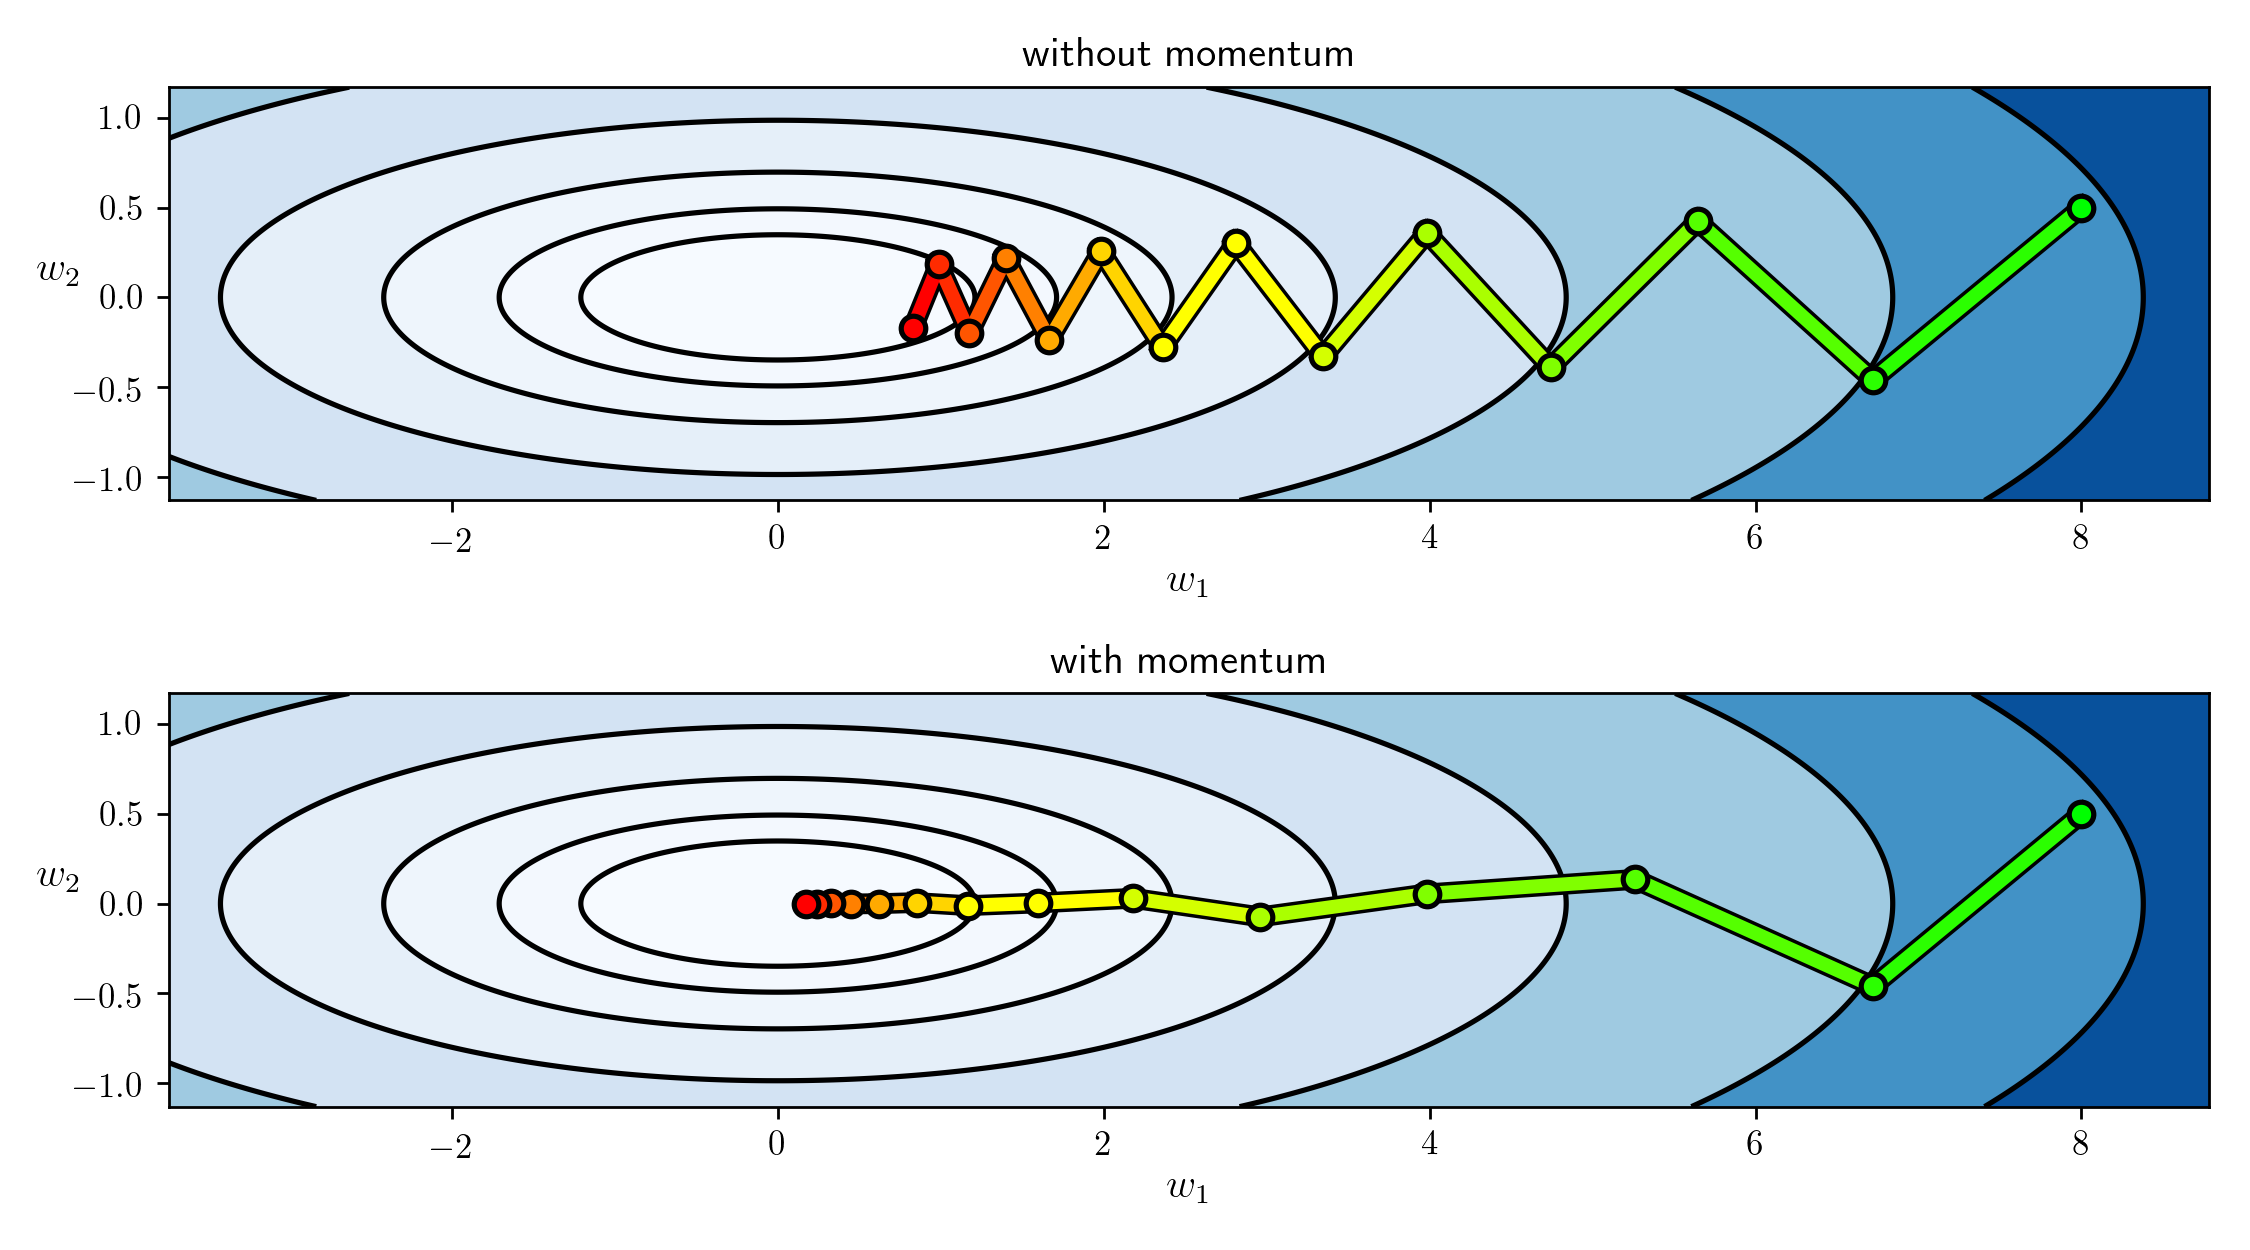

In [5]:
# visualize
demo = nonlib.contour_run_comparison.Visualizer()
demo.show_paths(g, weight_history_1,weight_history_4,num_contours = 20)

- For example, take the quadratic 

\begin{equation}
g(\mathbf{w}) = a + \mathbf{b}^T\mathbf{w} + \mathbf{w}^T\mathbf{C}\mathbf{w}
\end{equation}

where $a = 0$, $\mathbf{b} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$, and $\mathbf{C} = \begin{bmatrix} 0\,\,0 \\ 0 \,\, 12\end{bmatrix}$

In [6]:
# define constants for a N=2 input quadratic
a = 0
b = 2*np.ones((2,1))
b[1] = 0
C = np.array([[0,0],[0,12]])

# a quadratic function defined using the constants above
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

In [7]:
w_init = np.ones((2,1))
w_init[1] = 2
w_init[0] = 12

# w_init = np.random.randn(2,1)
alpha = 8.3*10**(-2)
max_its = 30
version = 'unnormalized'

# use momentum with beta = 0
beta = 0
weight_history_1 = gradient_descent(g,w_init,alpha,max_its,beta,version)

# use momentum with beta = 0.8
beta = 0.7
weight_history_2 = gradient_descent(g,w_init,alpha,max_its,beta,version)

<IPython.core.display.Javascript object>


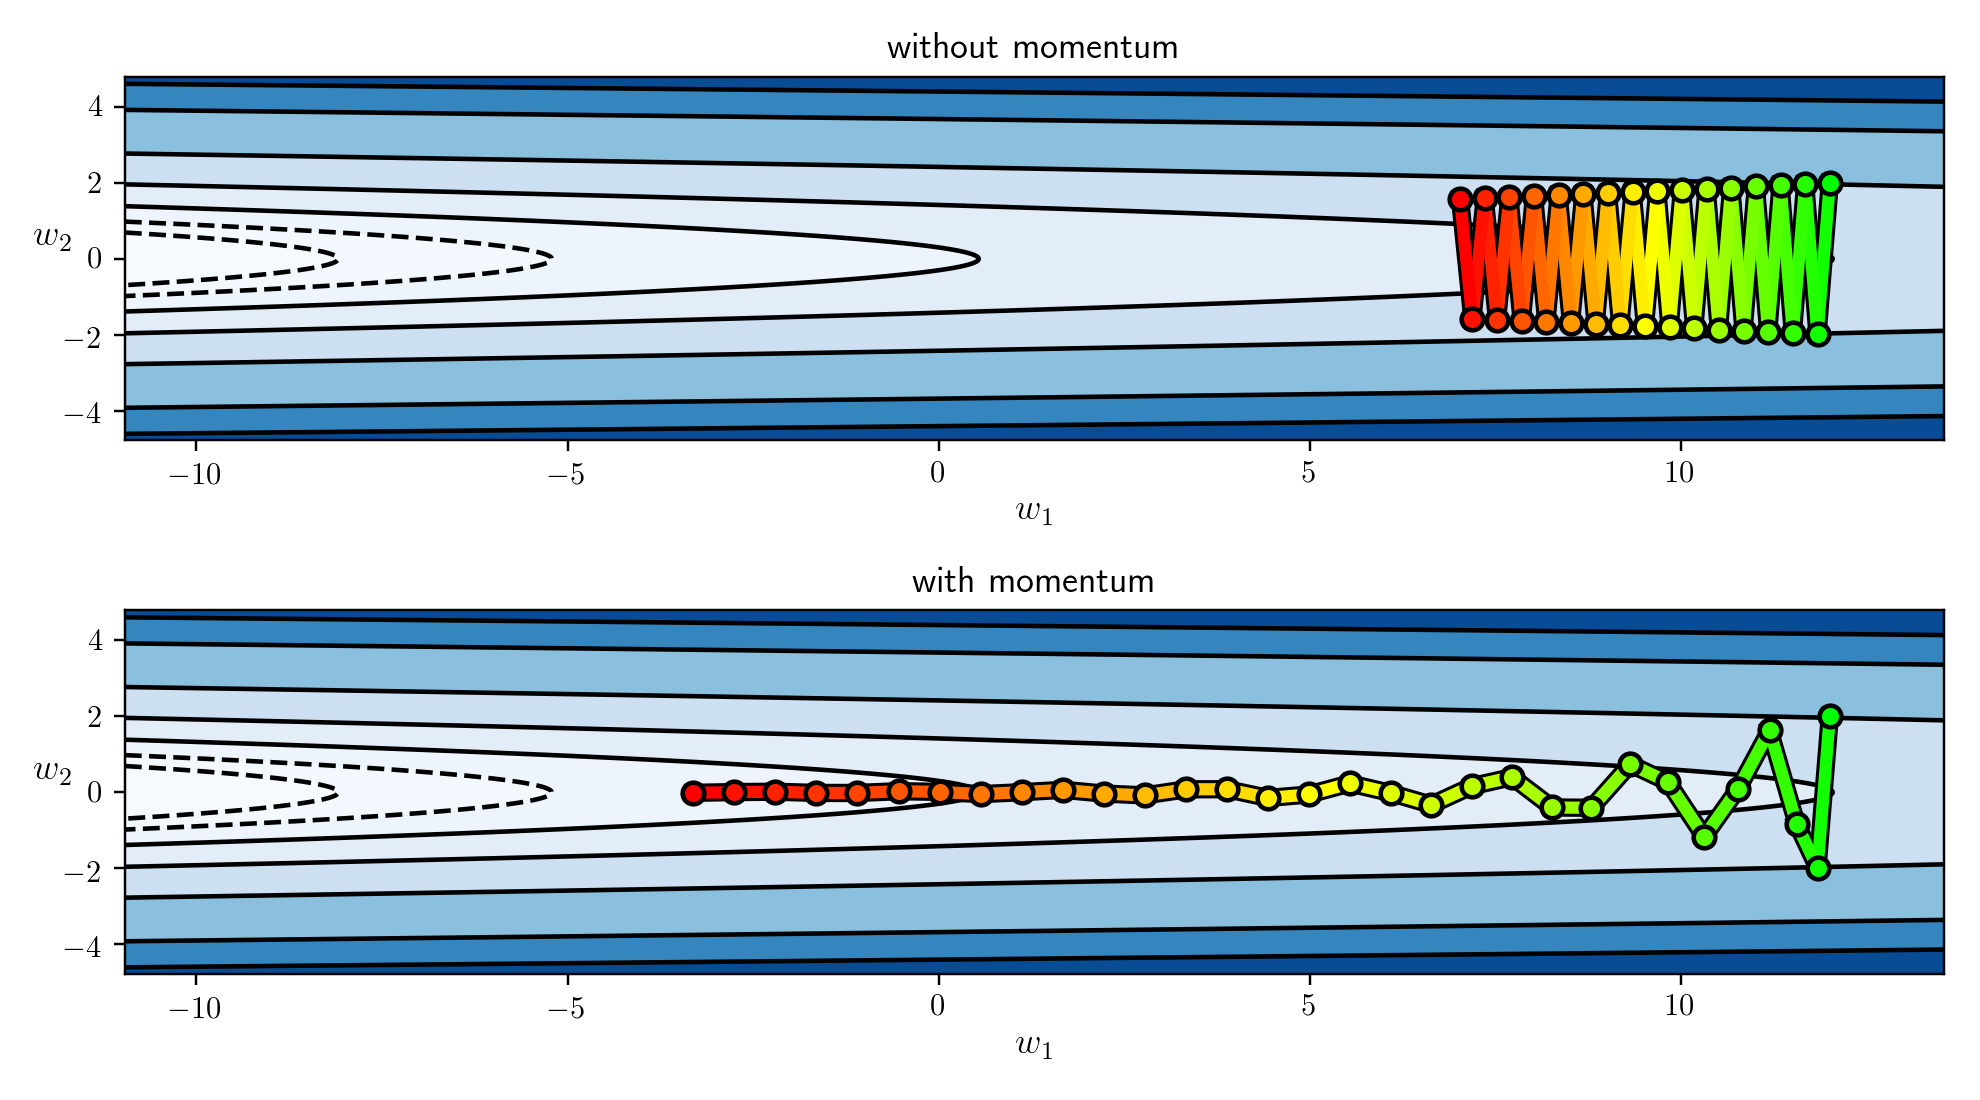

In [8]:
# visualize
demo = nonlib.contour_run_comparison.Visualizer()
demo.show_paths(g, weight_history_1,weight_history_2,num_contours = 20)

#### <span style="color:#a50e3e;">Example 2. </span>  Using momentum to speed up the minimization of linear two-class classification

In [11]:
# tanh non-convex logistic least squares cost function
def tanh_least_squares(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        cost +=(np.tanh(w[0] + w[1]*x_p) - y_p)**2
    return cost

# load in dataset
csvname = datapath + '2d_classification_data_v1.csv'
data = np.loadtxt(csvname)

# define the input and output of our dataset
x = data[:,0]
x.shape = (len(x),1)
y = data[:,1]
y.shape = (len(y),1)

In [12]:
w_init = np.zeros((2,1))
w_init[0] = 0
w_init[1] = 0
# w_init = np.random.randn(2,1)
alpha = 1
max_its = 25
version = 'normalized'

# use momentum with beta = 0
beta = 0
weight_history_1 = gradient_descent(tanh_least_squares,w_init,alpha,max_its,beta,version)


# use momentum with beta = 0.9
beta = 0.99
weight_history_4 = gradient_descent(tanh_least_squares,w_init,alpha,max_its,beta,version)


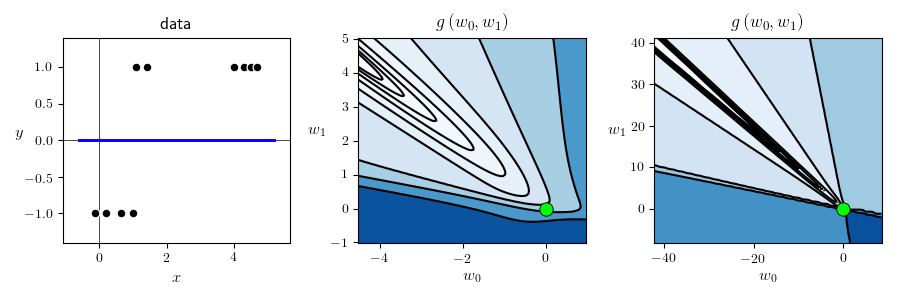
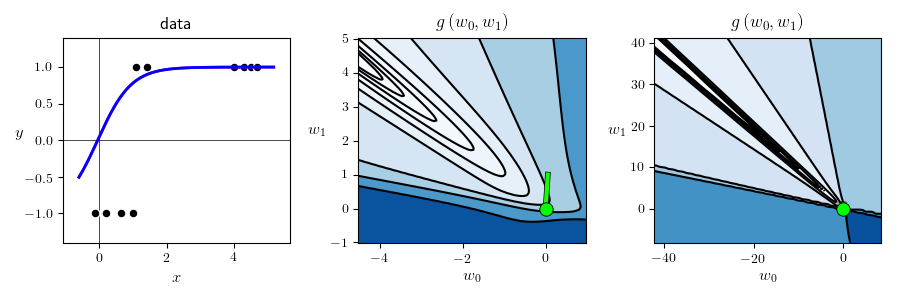
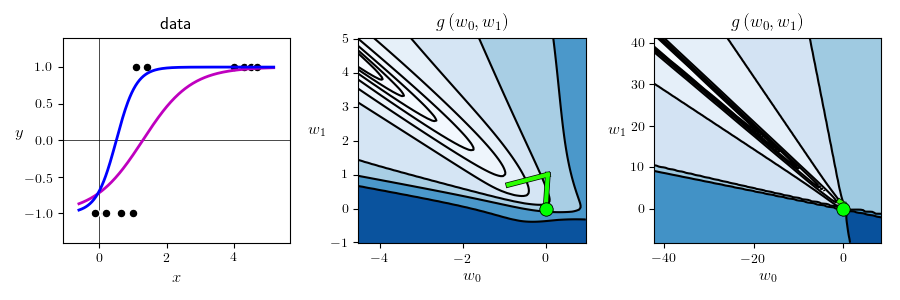
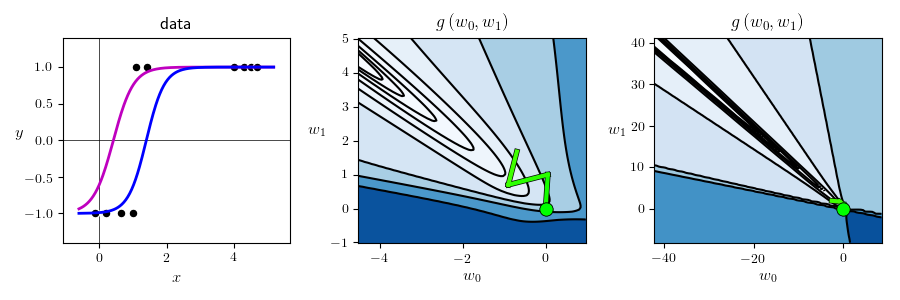
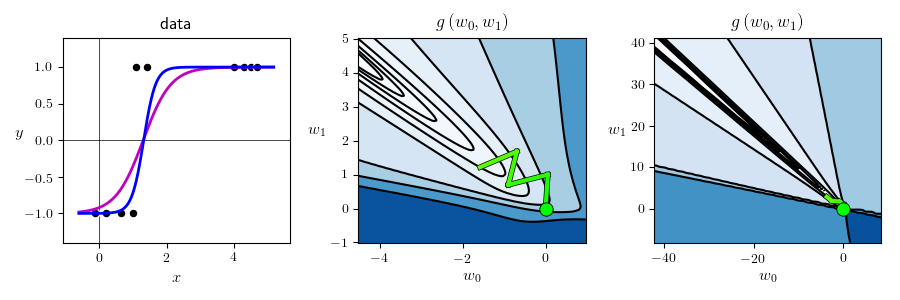
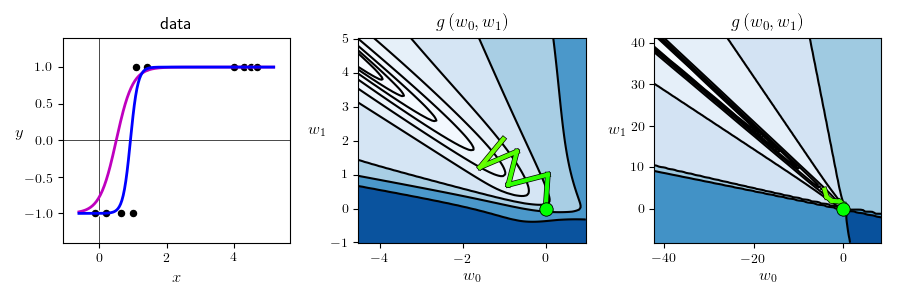
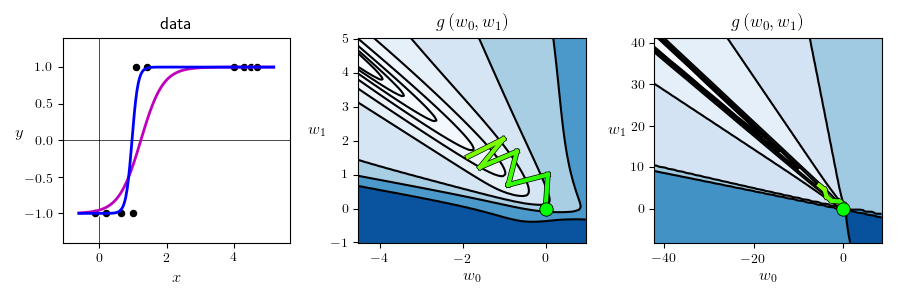
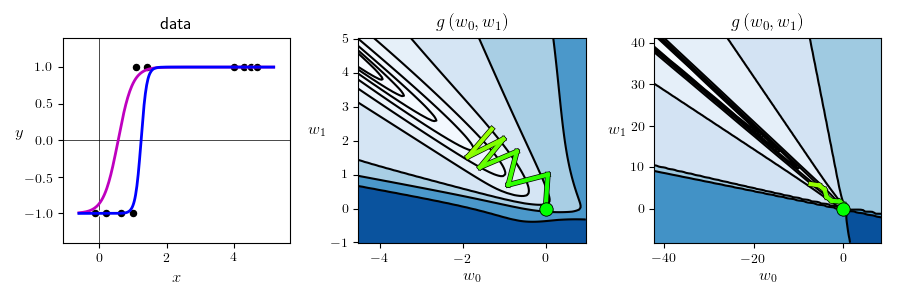
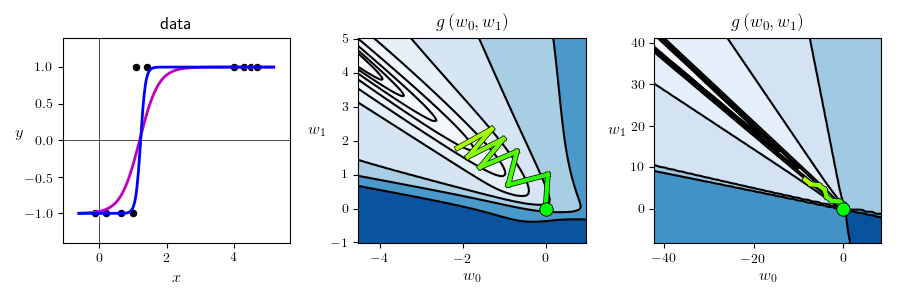
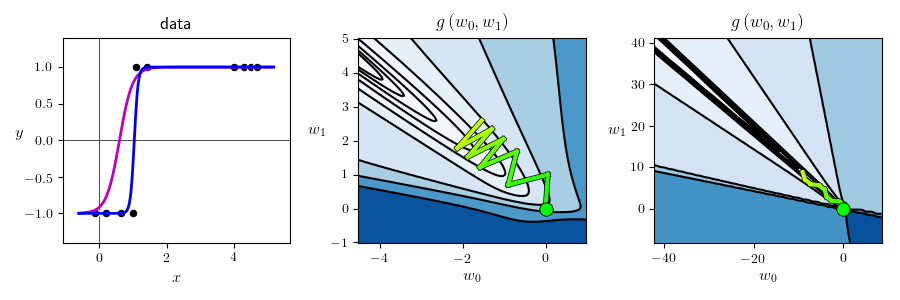
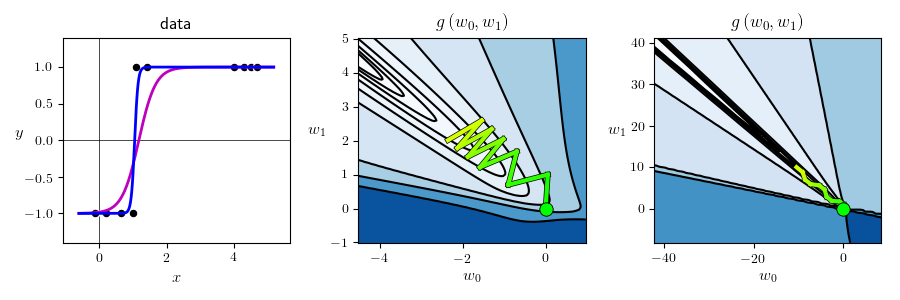
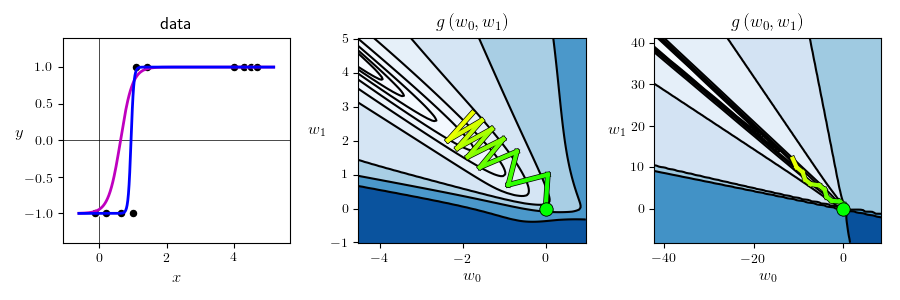
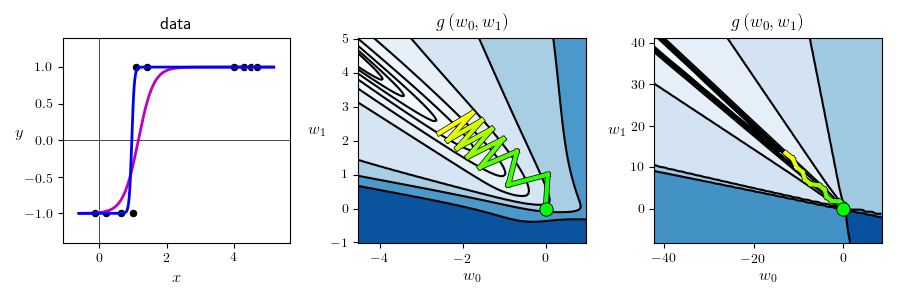
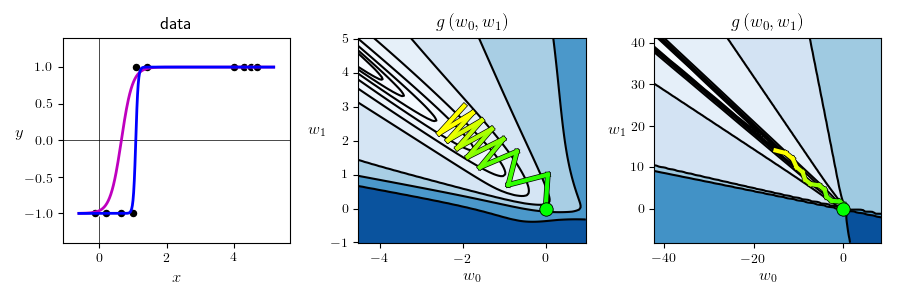
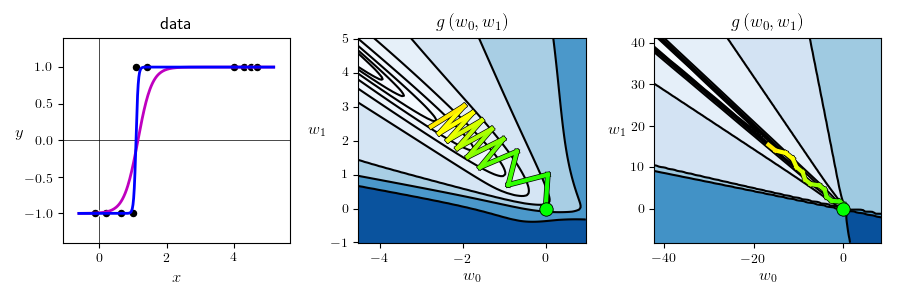
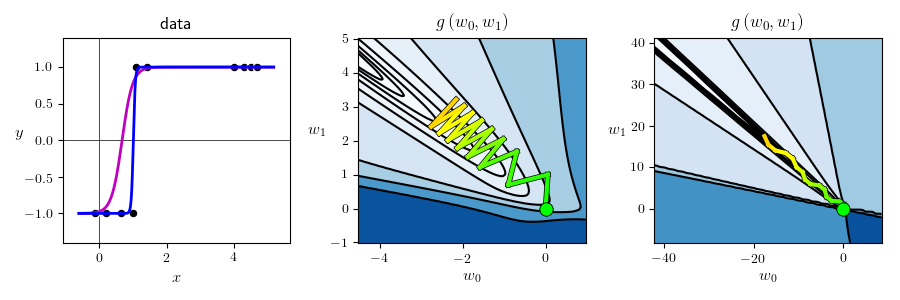
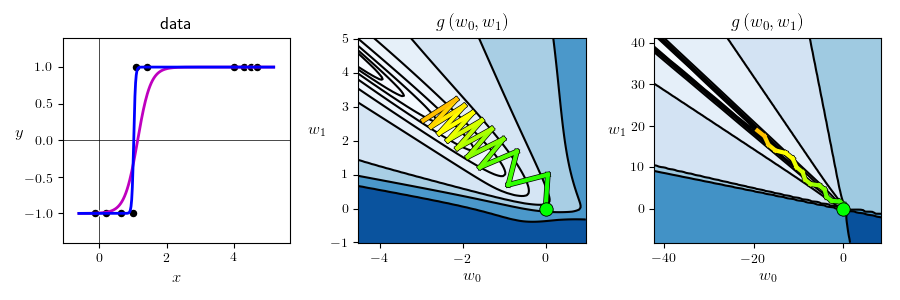
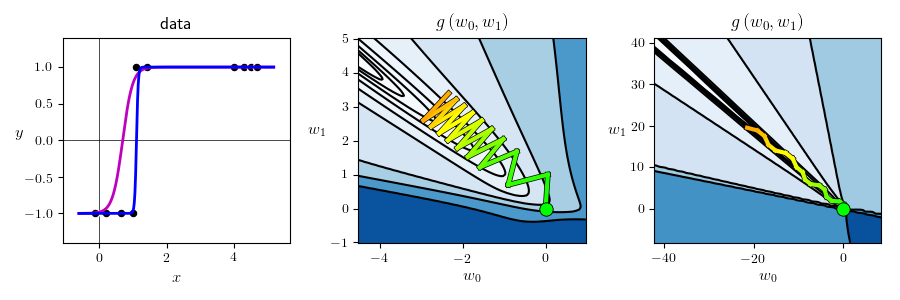
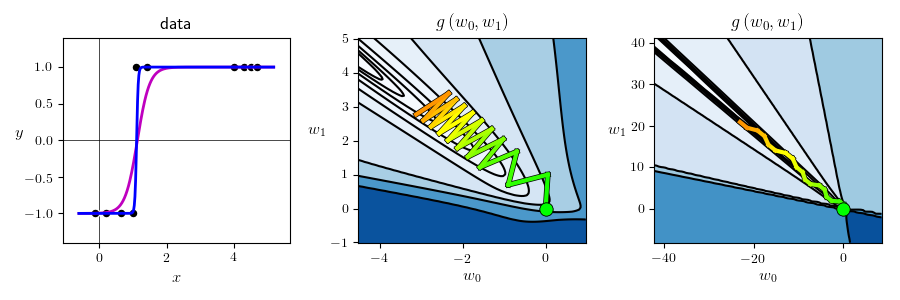
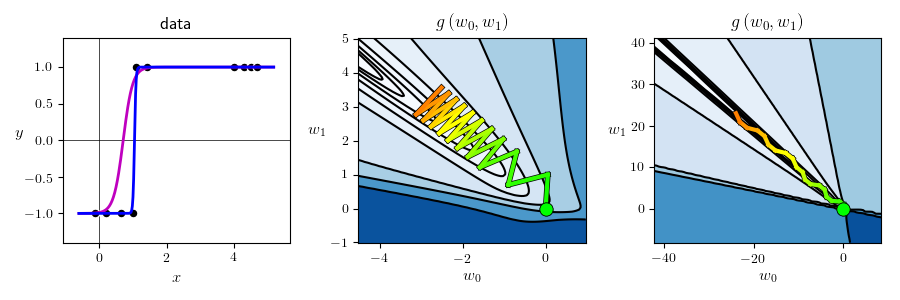
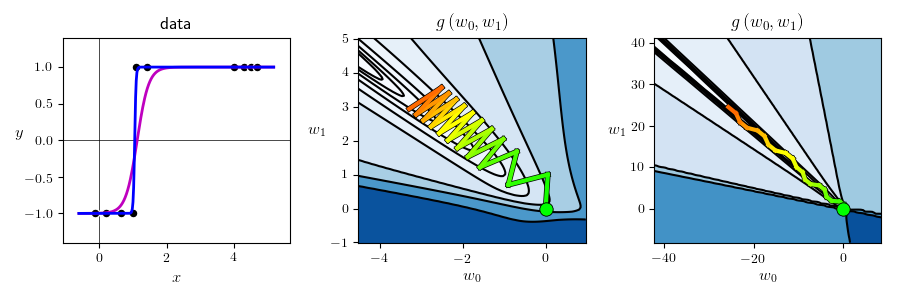
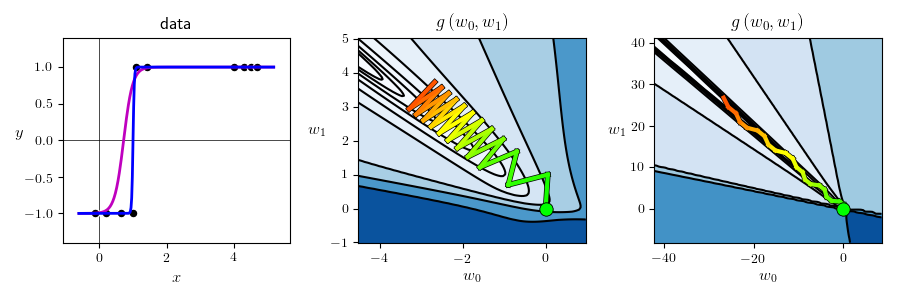
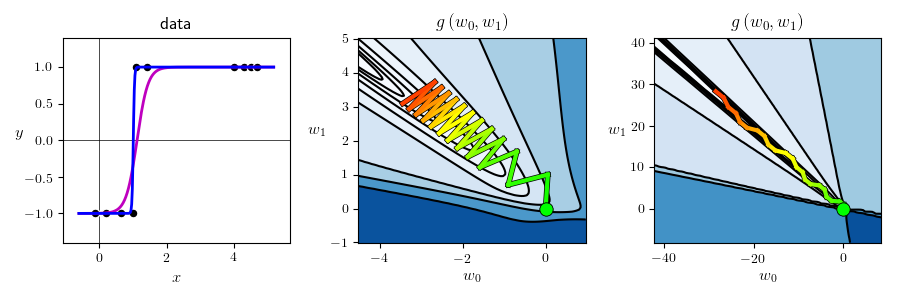
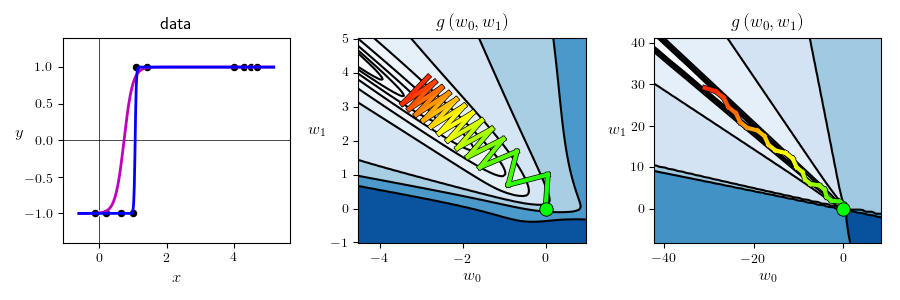
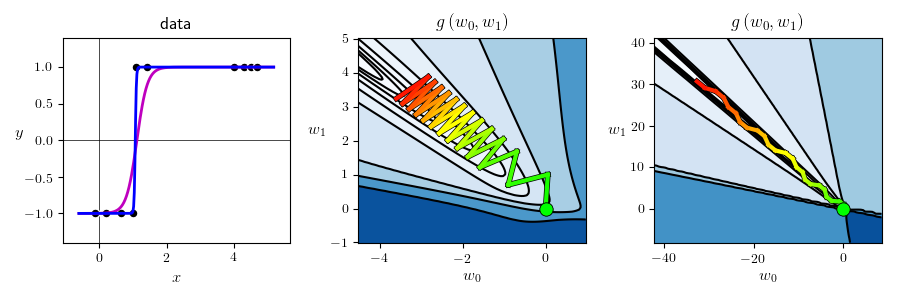
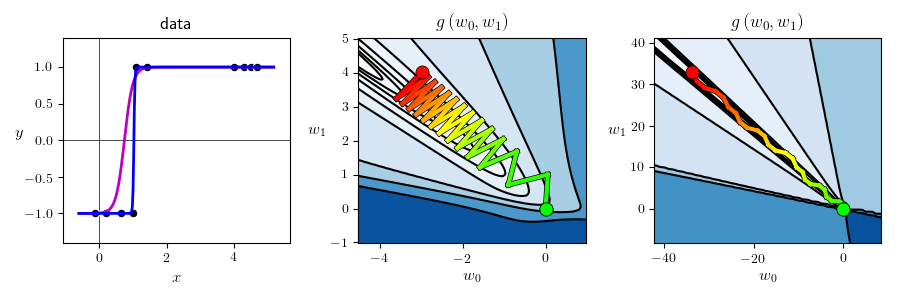

In [14]:
# create instance of logisic regression demo and load in data, cost function, and descent history
demo3 = nonlib.classification_2d_demos_v2.Visualizer(data,tanh_least_squares)

# animate descent process
demo3.animate_runs(weight_history_1,weight_history_4,num_contours = 25)